# Overview: 7-day weather forecast plot

The code in this jupyter notebook walks through generating plots to represent a 7 day forecast (inspired by the Apple Weather app) using `plotnine`.
Here is an example of a finished plot:

![7-day forecast](img/weather.png)
<img src="img/weather.png" />

The plot uses:
* `geom_path` to draw temperature ranges (`geom_line` would have worked just as well)
* `geom_text` to label the high and low temperatures
* `watermark` to display the weather icons

The remaining plot components are the `title`, `subtitle`, and `y-axis` labels.

The icons were modified from the open source icon library, [Bootstrap Icons](https://icons.getbootstrap.com/): I colorized the icons and saved them as PNGs.
Thanks to the Bootstrap team and contributors for Bootstrap Icons and the Bootstrap framework.

The trickier parts of creating this plot are getting the color gradient right and positioning the icons.
The most time-consuming part is tweaking the plot's theme to polish the plot's look including placement and styling of elements.

If you want to skip past the prototypes that eventually led to the final product, jump to the [Final Plot](#final-plot) section.
After working out how I want the plot to look, I write a function to facilitate generating additional plots at the end of this notebook.

## Imports

The code uses `polars` to read in the raw data and manipulate it to be ready to create the plot in `plotnine`.
Here is an example table of raw data:

| Day | Low | High | Conditions |
|-------|-----|------|---------------|
| Today | 65 | 77 | Cloudy |
| Mon | 61 | 84 | Sunny |
| Tue | 67 | 93 | Hot |
| Wed | 59 | 76 | Drizzle |
| Thu | 54 | 75 | Windy |
| Fri | 57 | 81 | Party cloudy |
| Sat | 60 | 71 | Heavy rain |

In [1]:
import polars as pl
import plotnine as p9

pl.__version__, p9.__version__

('0.20.13', '0.13.6')

# First prototype

Let's generate a first prototype of a plot to figure out if/how the data needs to be prepped for plotting, try out different strategies, and get a feel for how the data can be represented.
This first prototype tries using `geom_segment`, but the final plot uses `geom_path`.

## Import data

`geom_segment` requires `x`, `xend`, `y`, and `yend` aesthetics.
We can map "Low" and "High" to `x` and `xend`, respectively, and "Day" to `y` and `yend`.

We can use the raw data with `geom_segment` with minimal work: we'll just want to type the "Day" column as a categorical column to establish the correct plotting order.
If we don't do this, the days will be plot in alphabetical order.

Since this is just a 7-day forecast, we don't need to worry about non-unique "Day" values.
If there were non-unique "Day" values, we would need a different strategy such as using a unique value to order the days while using the "Day" value for labeling.

Don't be concerned about the "Conditions" column for now.
We'll figure out what, if anything, to do with it after figuring out most of the other parts.

In [2]:
raw_data = pl.read_csv('./data/7-day_forecast.csv')
raw_data = raw_data.with_columns(pl.col('Day').cast(pl.Categorical))
raw_data

Day,Low,High,Conditions
cat,i64,i64,str
"""Today""",65,77,"""Cloudy"""
"""Mon""",61,84,"""Sunny"""
"""Tue""",67,93,"""Hot"""
"""Wed""",59,76,"""Drizzle"""
"""Thu""",54,75,"""Windy"""
"""Fri""",57,81,"""Partly cloudy"""
"""Sat""",60,71,"""Heavy rain"""


## Create plot

I'm not showing the most basic prototype below, but if you want to see it, comment out line 4 and uncomment line 5 in the code block below.

From the most basic prototype, I made the design choices that I want a thicker line, I want round ends, and I want color in the line, ideally a color gradient.
The first prototype on display below shows attempts at working towards the design choices.

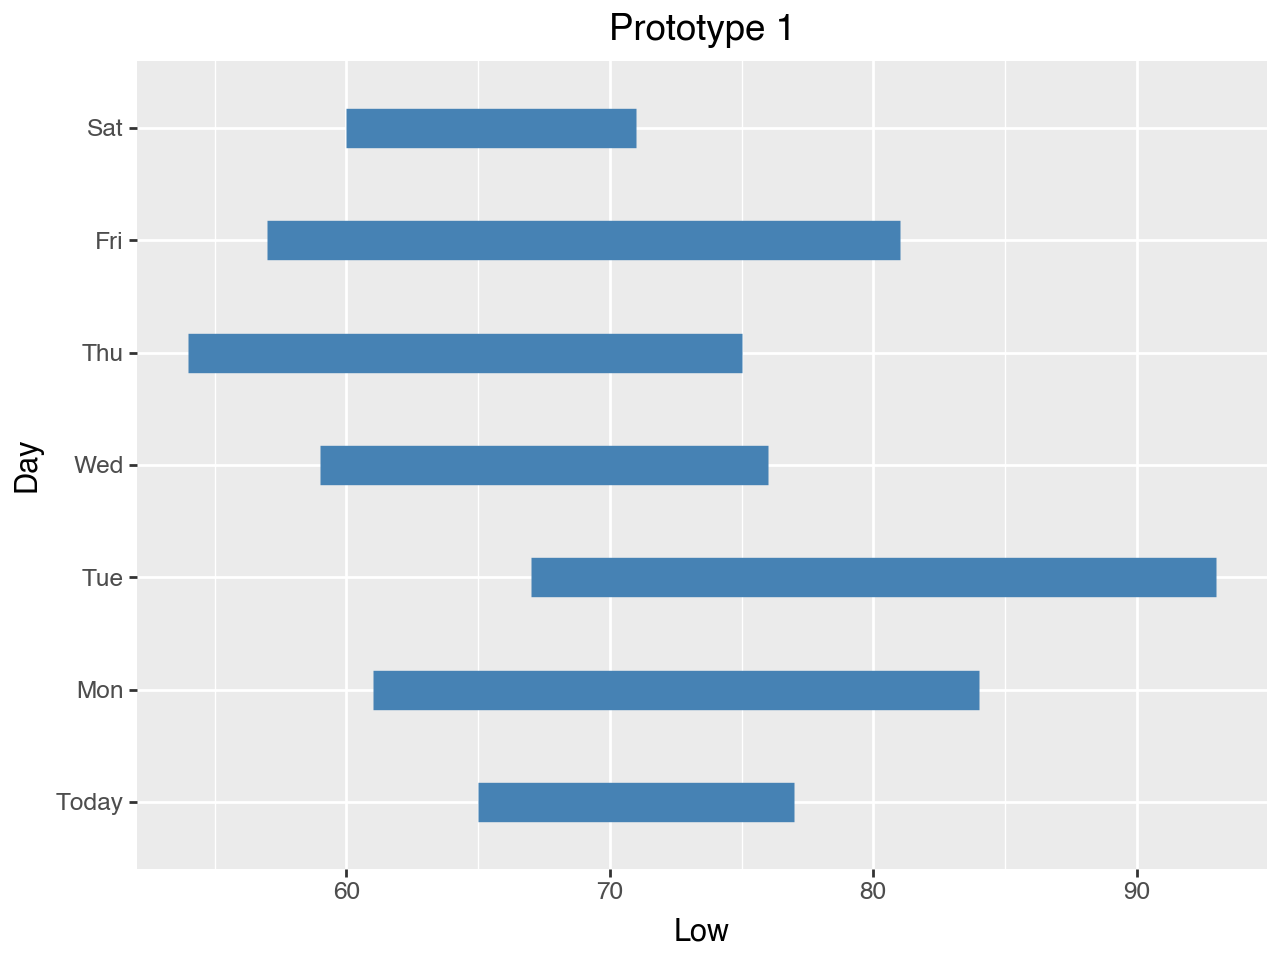

In [3]:
plot = (
    p9.ggplot(raw_data, p9.aes(x='Low', xend='High', y='Day', yend='Day'))
    + p9.labs(title='Prototype 1')
    + p9.geom_segment(size=8, lineend='round', color='steelblue')
    # + p9.geom_segment()
)
plot.show()

## Prototype 1 learnings

The plot is starting to come together a little bit but there are a few things to take from this prototype:

1. The days are on the y-axis where low ordinality is at the bottom and high ordinality is at the top (opposite of what I want)
1. The line ends are not rounded
1. A color gradient is going to require some work

There are a couple of strategies we can use to get the days ordered the way I want: we can either reverse the ordinality of the days in the dataframe or we can flip the y-axis.
We can't use `scale_y_reverse` because we do not have continuous values, but we can use `scale_y_discrete` and set the limits in reverse order.
I use `scale_y_discrete` to reverse the order as demonstrated below.

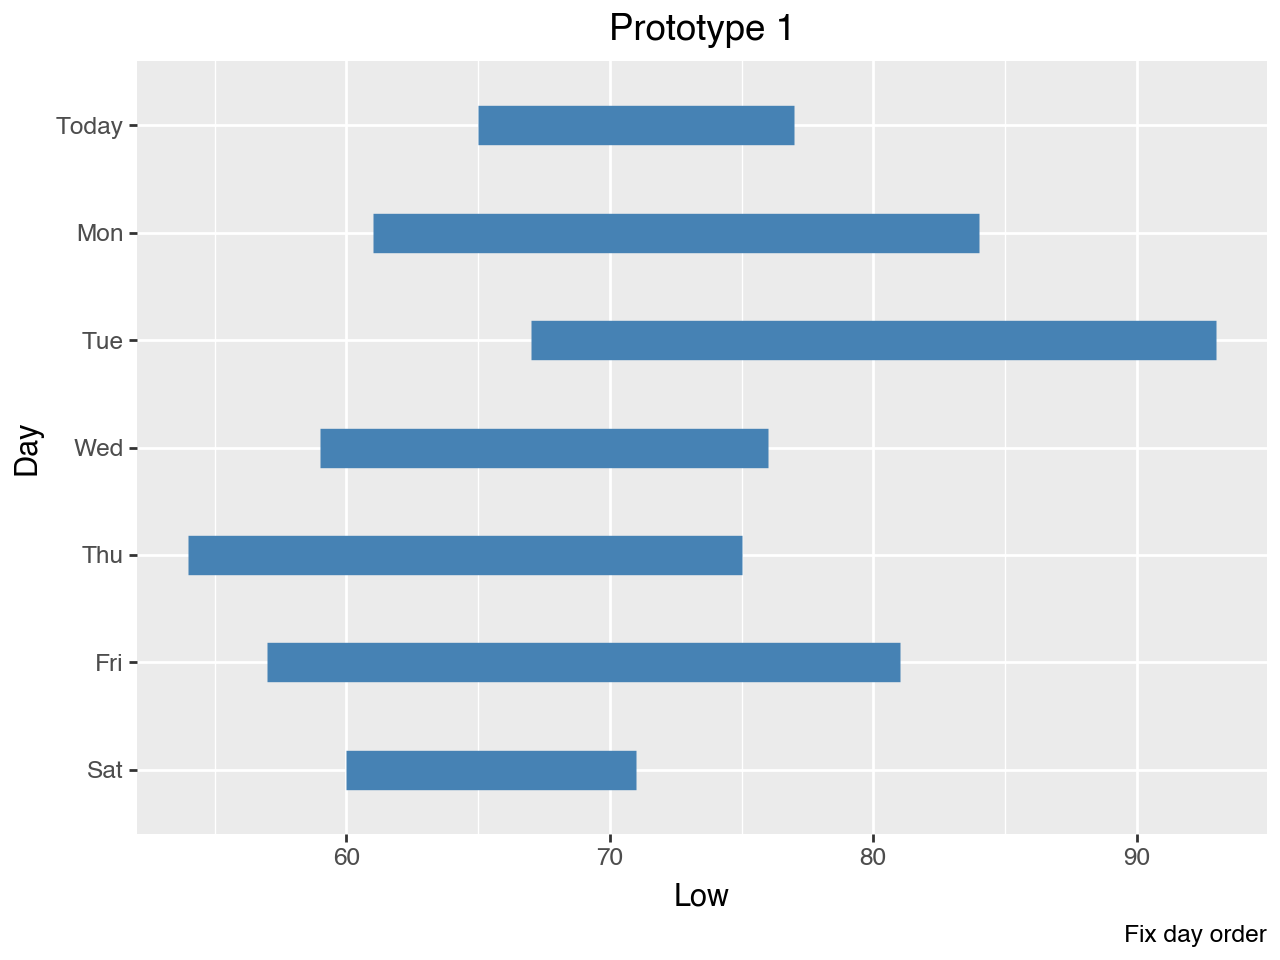

In [4]:
# reverse order of the days with scale_y_discrete
(
    plot
    + p9.labs(title='Prototype 1', caption='Fix day order')
    + p9.scale_y_discrete(limits=raw_data['Day'].reverse().to_list())
).show()

It looks like `geom_segment` doesn't produce round ends although the code specifies `lineend='round'`.
I'd like to dig into the code a bit to see if this observation might be similar to this [issue](https://github.com/has2k1/plotnine/issues/727) and [commit](https://github.com/has2k1/plotnine/commit/18b748fab0c8b0c6e9ab28090982ecf2c054cefc) but I don't have cycles available to do that right now.

Before moving on, let's try one thing with `geom_segment` and a color gradient.
I create a simple dataframe that has data to draw horizontal line segments at y=1.
Each line segment has a `z` value ranging from 0 - 1 which we map to the color aesthetic.

In [5]:
plot_data = pl.DataFrame({
    'x': list(range(1, 11)),
    'y': [1] * 10,
    'z': [0] * 3 + [0.2, 0.4, 0.6, 0.8]  + [1] * 3
})
plot_data = plot_data.with_columns(
    xend = pl.col('x') + 1
)
plot_data

x,y,z,xend
i64,i64,f64,i64
1,1,0.0,2
2,1,0.0,3
3,1,0.0,4
4,1,0.2,5
5,1,0.4,6
6,1,0.6,7
7,1,0.8,8
8,1,1.0,9
9,1,1.0,10


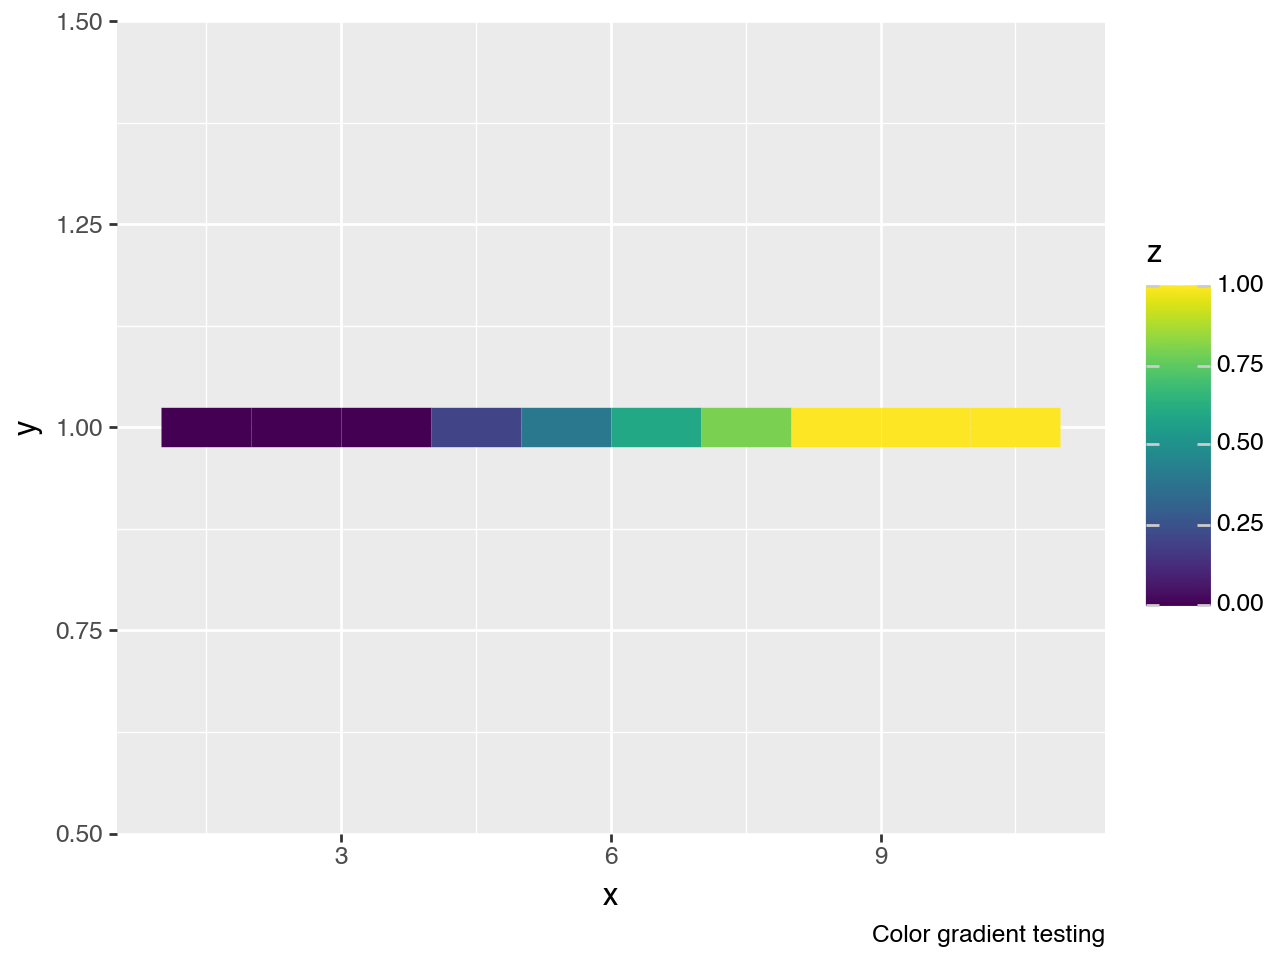

In [6]:
plot = (
    p9.ggplot(plot_data, p9.aes(x='x', xend='xend', y='y', yend='y', color='z', group=1))
    + p9.labs(caption='Color gradient testing')
    + p9.geom_segment(size=8, lineend='round', raster=True)
)
plot.show()

Here's the start of a color gradient effect, but we'll need a lot more segments to get a smooth gradient.
If you zoom in and take a close look at the segments, there are seams between the segments and there's still the issue with not having rounded ends.
We could deal with the seams by plotting overlapping line segments and try using `geom_point`s to simulate rounded ends, but these workarounds suggest that it's worth considering what other approaches might be out there.
Let's move on to trying `geom_path`.

# Second prototype

Let's try using `geom_path`; this is a geom that I almost never use, but its [reference page](https://plotnine.org/reference/geom_path.html) shows a promising example with a color gradient at the very bottom.
We'll try here again to get a rounded end too.
In retrospect, I could have used `geom_line` instead, but the reference page for `geom_path` is where the inspiration for the color gradient originated from.

## Import data

`geom_path` requires `x` and `y` aesthetics where it connects points according to their order in the dataframe.
I want to map a temperature to `x` and "Day" to `y`, so I need the Low and High temperatures for each day to be separated to different rows.
This will require reshaping the data: in this case, we'll melt the data from wide to long format so that we have "Temperature" (`x`) and "Day" (`y`) columns.

I'm going to work from the raw_data that was read in previously where Day is a categorical column.

In [7]:
plot_data = (
    raw_data
    .melt(id_vars=['Day'], value_vars=['High', 'Low'], variable_name='Low/High', value_name='Temperature')
    .sort(['Day', 'Temperature'], descending=False)
)
plot_data

Day,Low/High,Temperature
cat,str,i64
"""Today""","""Low""",65
"""Today""","""High""",77
"""Mon""","""Low""",61
"""Mon""","""High""",84
"""Tue""","""Low""",67
…,…,…
"""Thu""","""High""",75
"""Fri""","""Low""",57
"""Fri""","""High""",81


## Create plot

I had imagined/hoped that `geom_path` might be able to auto-calculate a color gradient for the line between each of the two points, but ultimately the plot below demonstrates that this isn't the case.

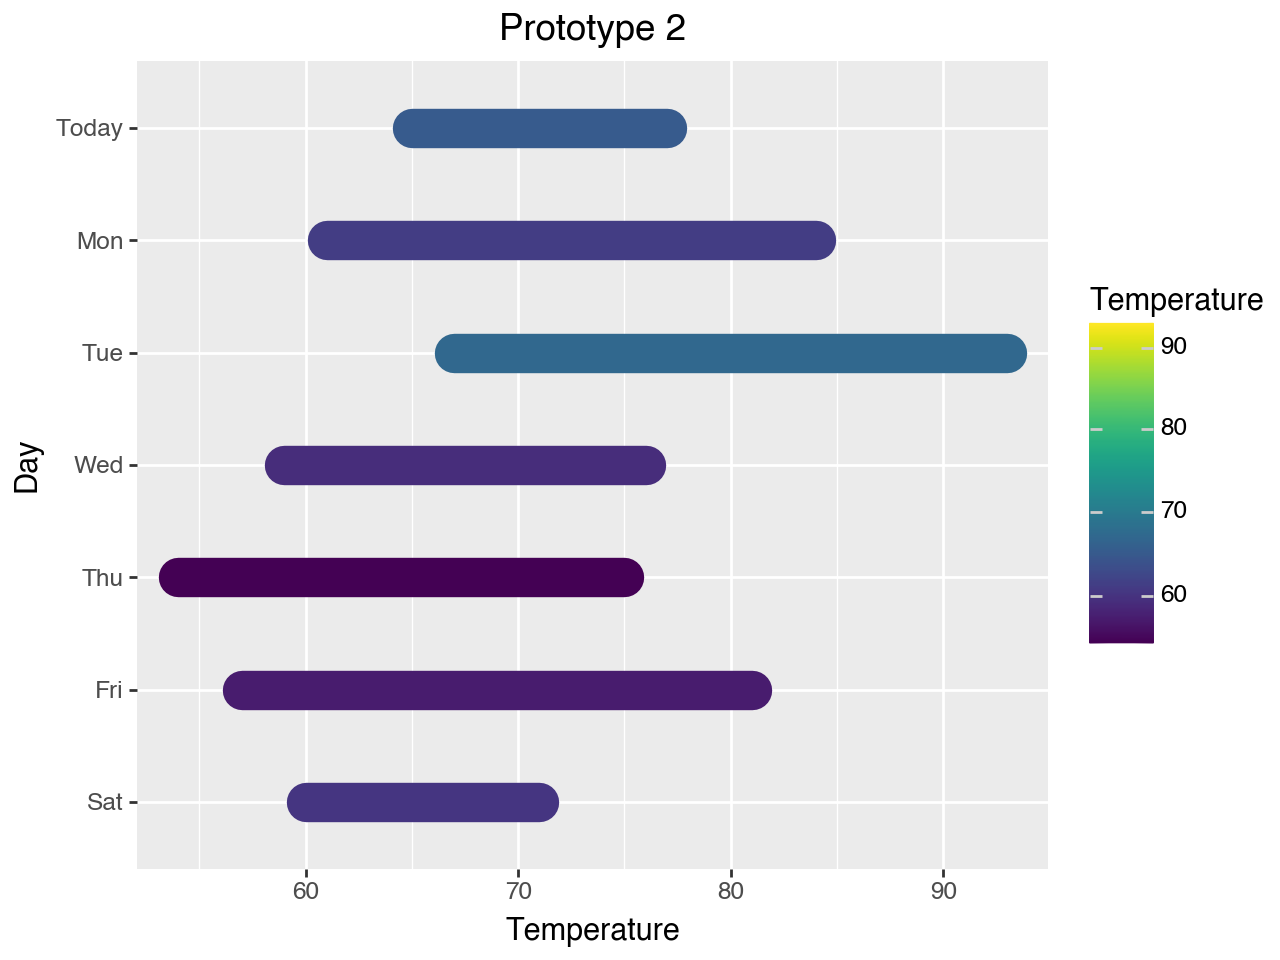

In [8]:
plot = (
    p9.ggplot(plot_data, p9.aes(x='Temperature', y='Day', color='Temperature'))
    + p9.labs(title='Prototype 2')
    + p9.geom_path(size=8, lineend='round')
    + p9.scale_y_discrete(limits=raw_data['Day'].reverse().to_list())
)
plot.show()

### No `group` aesthetic?

You might have noticed that the code above doesn't map anything to the `group` aesthetic.
Initially, I mapped "Day" to the `group` aesthetic, but it doesn't appear to matter in this case.
I believe it's because `y` is mapped to discrete rather than continuous values.
Look at the plot below to see what happens if `y` is mapped to continuous values without a `group` aesthetic.

Since we'll have continuous values, we can use `scale_y_reverse` to reverse the order of the days.

In [9]:
# prep dictionary to map days to numbers
days = plot_data.get_column('Day').unique(maintain_order=True)
days = dict(zip(days, range(days.len())))
days

{'Today': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6}

In [10]:
# convert days to numbers in "Day_int" column
plot_data_test = plot_data.with_columns(
    pl.col('Day').cast(str).replace(days).cast(int).alias('Day_int')
)
plot_data_test

Day,Low/High,Temperature,Day_int
cat,str,i64,i64
"""Today""","""Low""",65,0
"""Today""","""High""",77,0
"""Mon""","""Low""",61,1
"""Mon""","""High""",84,1
"""Tue""","""Low""",67,2
…,…,…,…
"""Thu""","""High""",75,4
"""Fri""","""Low""",57,5
"""Fri""","""High""",81,5


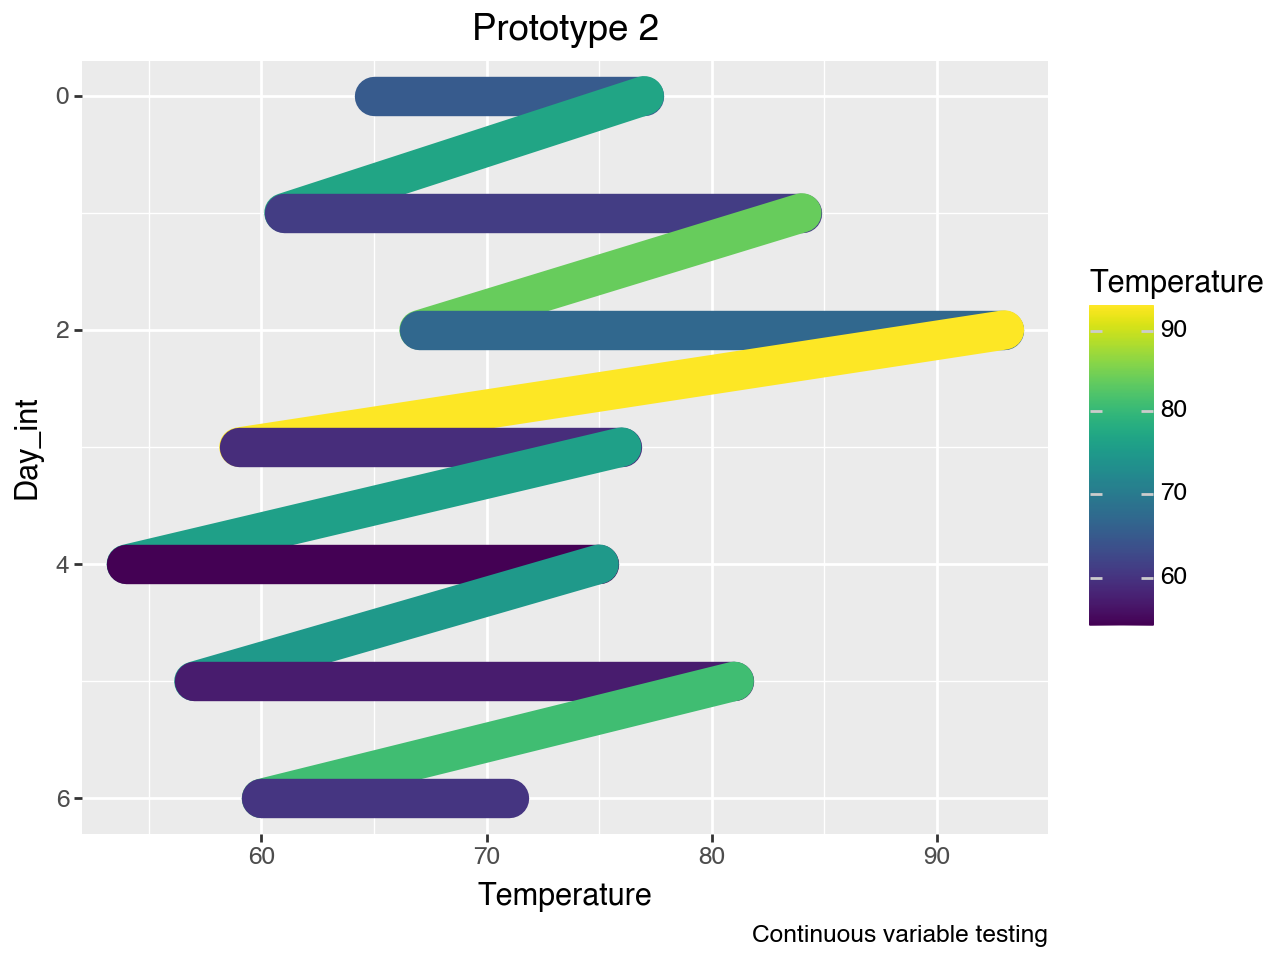

In [11]:
# plot with Day_int mapped to y; switch between commenting out lines 3 and 4 to see what happens
plot = (
    p9.ggplot(plot_data_test, p9.aes(x='Temperature', y='Day_int', color='Temperature'))
    # p9.ggplot(plot_data_test, p9.aes(x='Temperature', y='Day_int', color='Temperature', group='Day_int'))
    + p9.labs(title='Prototype 2', caption='Continuous variable testing')
    + p9.geom_path(size=8, lineend='round')
    + p9.scale_y_reverse()
)
plot.show()

### Extra `geom_path` testing

The continuous variable testing plot above hints at this but let's take another look at what's going on with `geom_path` and the color: calculate a midpoint between Low and High and then remake the plot with `geom_path`.

In [12]:
plot_data = (
    raw_data
    .with_columns(Mid = (pl.col('High') + pl.col('Low')) / 2)
    .melt(id_vars=['Day'], value_vars=['High', 'Mid', 'Low'], variable_name='Low/High', value_name='Temperature')
    .sort(['Day', 'Temperature'], descending=False)
)
plot_data

Day,Low/High,Temperature
cat,str,f64
"""Today""","""Low""",65.0
"""Today""","""Mid""",71.0
"""Today""","""High""",77.0
"""Mon""","""Low""",61.0
"""Mon""","""Mid""",72.5
…,…,…
"""Fri""","""Mid""",69.0
"""Fri""","""High""",81.0
"""Sat""","""Low""",60.0


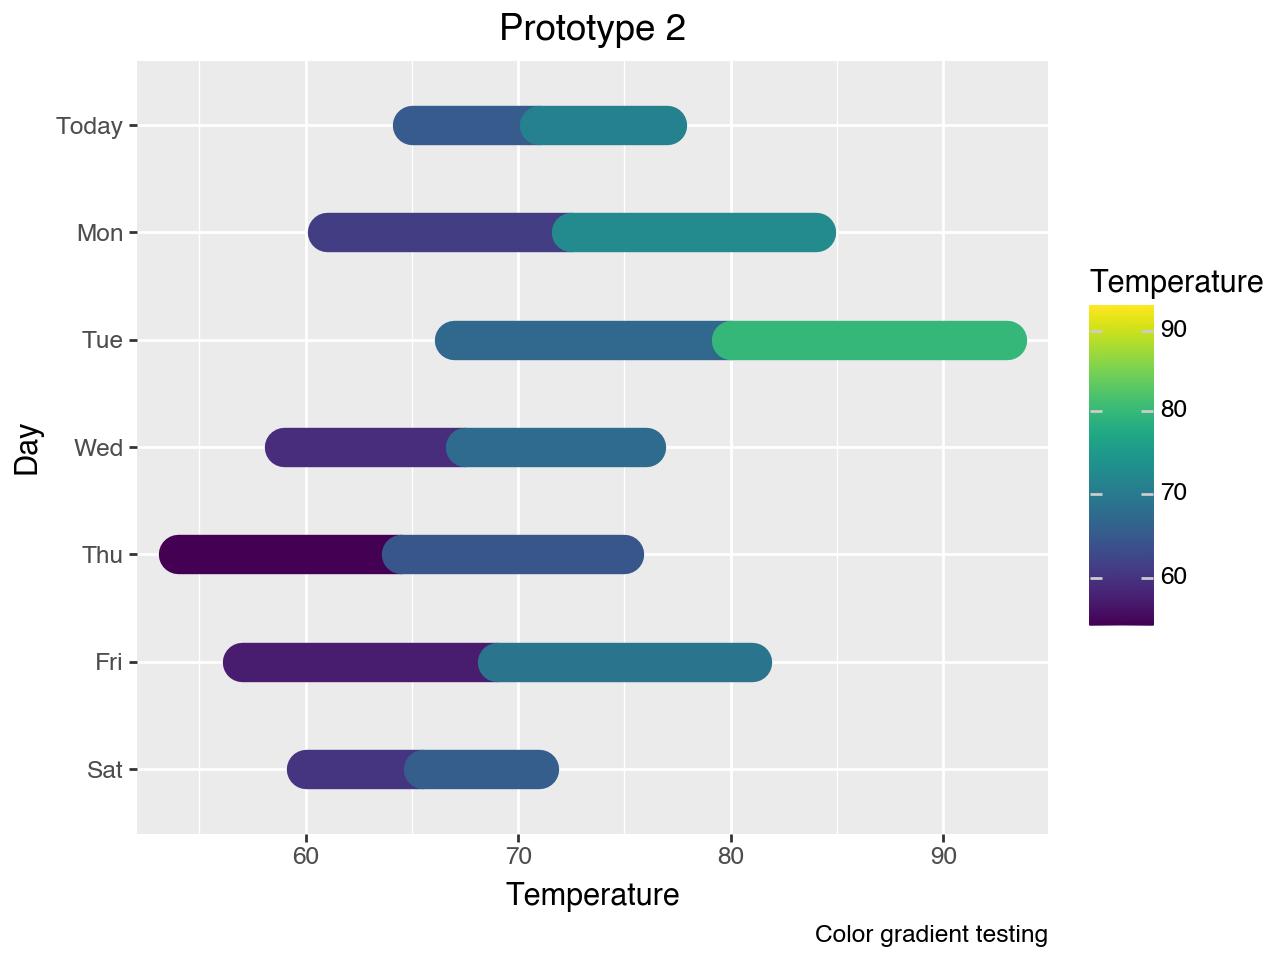

In [13]:
plot = (
    p9.ggplot(plot_data, p9.aes(x='Temperature', y='Day', color='Temperature'))
    + p9.labs(title='Prototype 2', caption='Color gradient testing')
    + p9.geom_path(size=8, lineend='round')
    + p9.scale_y_discrete(limits=raw_data['Day'].reverse().to_list())
)
plot.show()

## Prototype 2 learnings

1. Rounded ends works for `geom_path`
1. `geom_path` does not change color until the next data point

A color gradient is going to require some more work but `geom_path` looks like it has potential to do the job.


# Temperature info prototypes

Let's move quickly through a couple prototypes that get all of the temperature info onto the plot.

We'll use `geom_path` still, but we're going to create a dataframe which has a row for every 0.1 degree between the Low and High temperatures on each day.
This is let us get a nice color gradient for the temperature range.

In [14]:
# reminder: this is what raw_data looks like
raw_data

Day,Low,High,Conditions
cat,i64,i64,str
"""Today""",65,77,"""Cloudy"""
"""Mon""",61,84,"""Sunny"""
"""Tue""",67,93,"""Hot"""
"""Wed""",59,76,"""Drizzle"""
"""Thu""",54,75,"""Windy"""
"""Fri""",57,81,"""Partly cloudy"""
"""Sat""",60,71,"""Heavy rain"""


In [15]:
# create "Temperature" column that is a list of values from Low to High by 0.1 increments
plot_data = (
    raw_data
    .with_columns(
        Temperature = pl.int_ranges(pl.col('Low') * 10, pl.col('High') * 10 + 1).list.eval(pl.element() / 10)
    )
    .select('Day', 'Conditions', 'Temperature')
    .explode('Temperature')
)
plot_data

Day,Conditions,Temperature
cat,str,f64
"""Today""","""Cloudy""",65.0
"""Today""","""Cloudy""",65.1
"""Today""","""Cloudy""",65.2
"""Today""","""Cloudy""",65.3
"""Today""","""Cloudy""",65.4
…,…,…
"""Sat""","""Heavy rain""",70.6
"""Sat""","""Heavy rain""",70.7
"""Sat""","""Heavy rain""",70.8


## Color gradient prototype

Let's use our exploded out dataframe and see if the color gradient works.

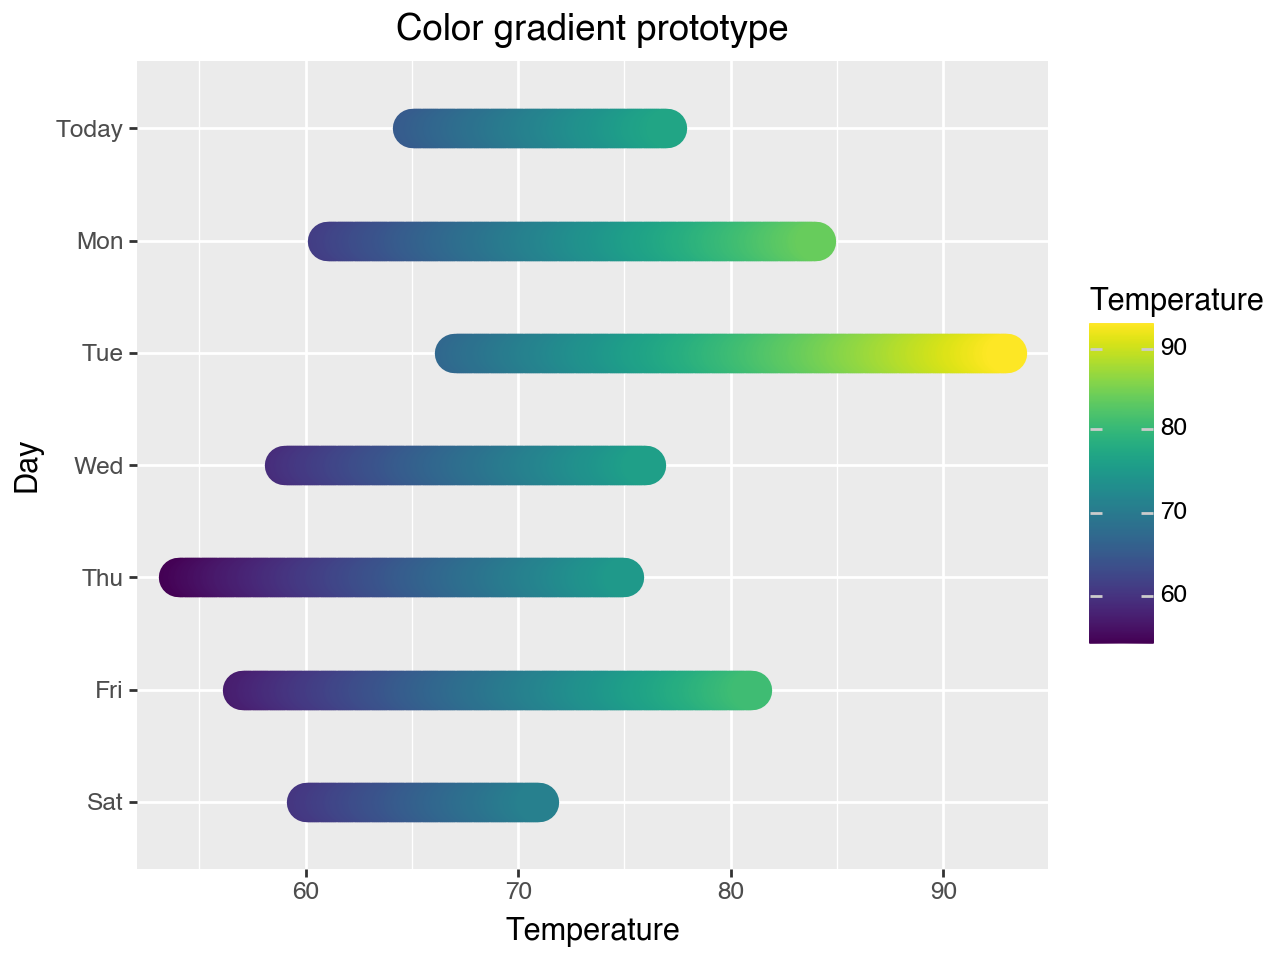

In [16]:
plot = (
    p9.ggplot(plot_data, p9.aes(x='Temperature', y='Day'))
    + p9.labs(title="Color gradient prototype")
    + p9.geom_path(p9.aes(color='Temperature'), size=8, lineend='round')
    + p9.scale_y_discrete(limits=raw_data['Day'].reverse().to_list())
)
plot.show()

The gradient looks good!
We'll change the color scale to something more appropriate to express temperature range later.

## Full temperature prototype

Let's add:

1. A 7-day range underneath the daily temperature range
1. Labels for the high and low temperatures to the plot

For the 7-day range, I want something that's underneath (on the z-axis) and a little larger than the temperature range.
The effect I want is a thin border around the edges, especially at the extreme low and high temperatures.
This means using a `geom_path` with a slightly larger `size` that spans from the lowest low temperature to the highest high temperature.
Then adding the daily temperature ranges with another `geom_path` that layers on top.
We'll create a dataframe to make the underlayment easy to add.

For the temperature labels, we'll use `geom_text` and create a dataframe with columns that can map to the `x`, `y`, and `label` aesthetics to make them easy to add.
The labels will be placed to the left and right of the full 7-day temperature range for each day.

In [17]:
low_high = [raw_data.get_column('Low').min(), raw_data.get_column('High').max()]
low_high

[54, 93]

In [18]:
# create dataframe for temperature range underlayment
temp_range = pl.DataFrame({
    'Day': raw_data.get_column('Day'),
    'Temperature': [low_high] * len(raw_data)
}).explode('Temperature')
temp_range

Day,Temperature
cat,i64
"""Today""",54
"""Today""",93
"""Mon""",54
"""Mon""",93
"""Tue""",54
…,…
"""Thu""",93
"""Fri""",54
"""Fri""",93


In [19]:
# create dataframe for temperature labels; the offset used here will look better in the final plot
x_offset = 5
temp_labels = (
    raw_data.lazy()
    .melt(id_vars=['Day', 'Conditions'], value_vars=['Low', 'High'], value_name='temperature')
    .with_columns(
        (pl.col('temperature').cast(str) + pl.lit('°')).alias('label'),
        pl.when(pl.col('variable') == 'Low')
        .then(pl.lit(low_high[0]) - x_offset)
        .otherwise(pl.lit(low_high[1]) + x_offset)
        .alias('x')
    )
    .sort('Day')
    .collect()
)
temp_labels

Day,Conditions,variable,temperature,label,x
cat,str,str,i64,str,i32
"""Today""","""Cloudy""","""Low""",65,"""65°""",49
"""Today""","""Cloudy""","""High""",77,"""77°""",98
"""Mon""","""Sunny""","""Low""",61,"""61°""",49
"""Mon""","""Sunny""","""High""",84,"""84°""",98
"""Tue""","""Hot""","""Low""",67,"""67°""",49
…,…,…,…,…,…
"""Thu""","""Windy""","""High""",75,"""75°""",98
"""Fri""","""Partly cloudy""","""Low""",57,"""57°""",49
"""Fri""","""Partly cloudy""","""High""",81,"""81°""",98


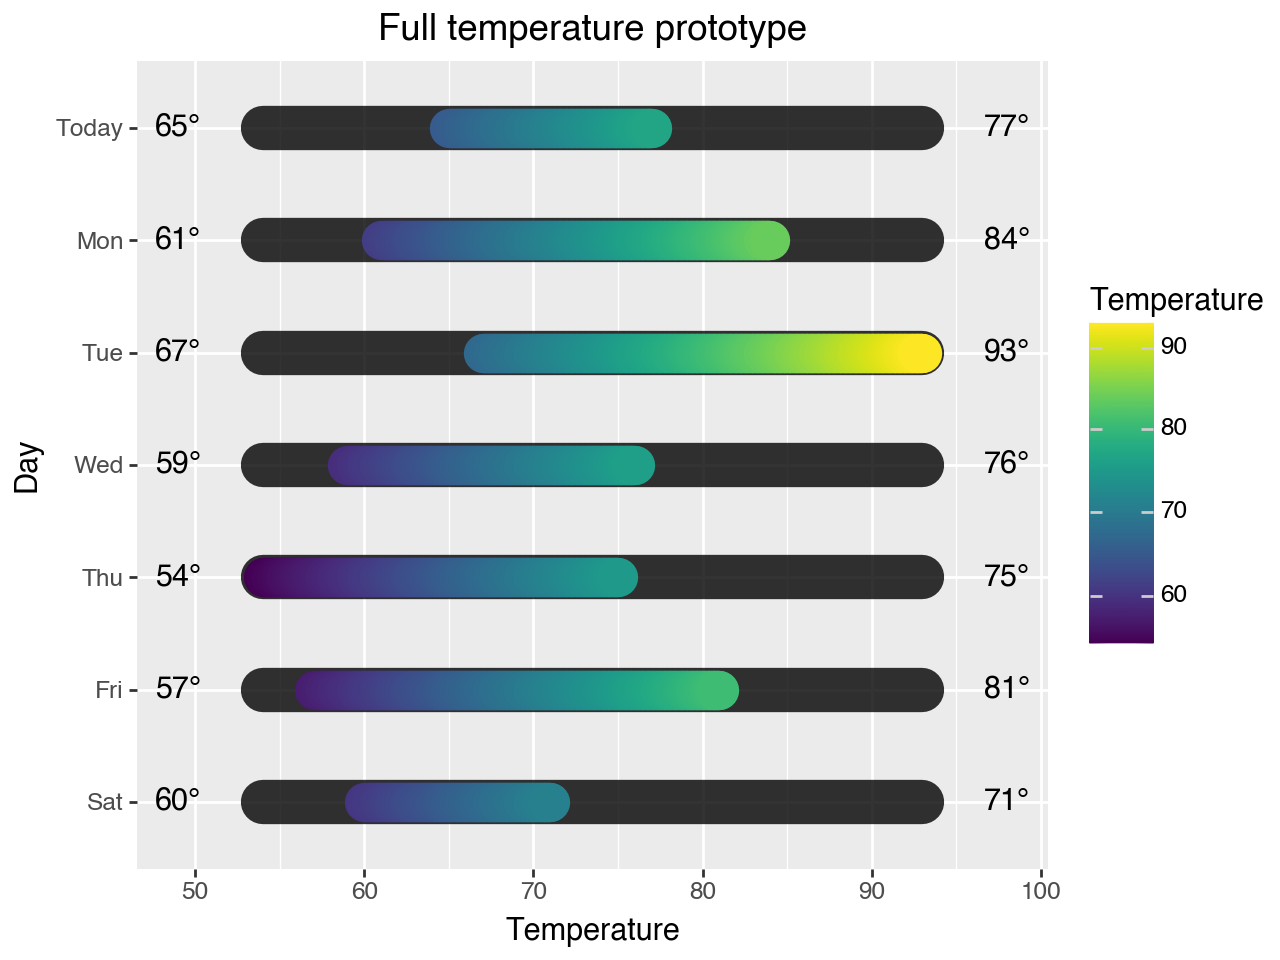

In [20]:
plot = (
    p9.ggplot(plot_data, p9.aes(x='Temperature', y='Day'))
    + p9.labs(title="Full temperature prototype")
    + p9.geom_path(data=temp_range, size=9, color='black', lineend='round', alpha=0.8)
    + p9.geom_path(p9.aes(color='Temperature'), size=8, lineend='round')
    + p9.geom_text(data=temp_labels, mapping=p9.aes(x='x', label='label'), ha='center', va='center')
    + p9.scale_y_discrete(limits=raw_data['Day'].reverse().to_list())
)
plot.show()

## Temperature info prototype learnings

* The color gradient in the temperature range and the underlayment work; we'll adjust the colors for the final plot
* The text labels are in place too: we'll adjust the placement and font size in the final plot

# Final plot

Let's leave the weather icons for the very end and work on polishing this plot.
This includes adjusting colors, placement, spacing, and sizes of elements and for a really polished plot, this part often takes the most time.
I won't go into detail about each adjustment, but will point out a few things below.

You'll see a version of the plot without icons first, and then a version with icons.

## Prep data

For convenience, here is all of the code to prep the data for the final plot in one place.


In [21]:
raw_data = pl.read_csv('./data/7-day_forecast.csv')
raw_data = raw_data.with_columns(pl.col('Day').cast(pl.Categorical))
low_high = [raw_data.get_column('Low').min(), raw_data.get_column('High').max()]

# daily temperature range data
plot_data = (
    raw_data
    .with_columns(
        Temperature = pl.int_ranges(pl.col('Low') * 10, pl.col('High') * 10 + 1).list.eval(pl.element() / 10)
    )
    .select('Day', 'Conditions', 'Temperature')
    .explode('Temperature')
)

# underlayment data
temp_range = pl.DataFrame({
    'Day': raw_data.get_column('Day'),
    'Temperature': [low_high] * len(raw_data)
}).explode('Temperature')

# text label data
x_offset = 5  # this is calculated dynamically in plot_forecast.py
temp_labels = (
    raw_data
    .melt(id_vars=['Day', 'Conditions'], value_vars=['Low', 'High'], value_name='temperature')
    .with_columns(
        (pl.col('temperature').cast(str) + pl.lit('°')).alias('label'),
        pl.when(pl.col('variable') == 'Low')
        .then(pl.lit(low_high[0]) - x_offset)
        .otherwise(pl.lit(low_high[1]) + x_offset)
        .alias('x')
    )
    .sort('Day')
)


## Plot without weather icons

Madison, WI is my current location and this is an actual 7-day forecast from late mid-June when I first started thinking about this.
I did take some liberty on Tuesday to increase the high temperature for reasons you'll see in the plot with icons.
Check line 11 to see how I define the color gradient.
I've left a gap for the weather icons to be added later, and this plot is going to get stretched out vertically. 

You'll notice that a lot of work happens in `theme()`.
Also, there are a few variables I define at the top and these are where I spent more time trying out different settings.
I had never used named colors from the [xkcd color name survey](https://matplotlib.org/stable/gallery/color/named_colors.html) before, but you can use them by placing `xkcd:` before the color name.

Final comment here on the tweaks: I use Arial instead of Helvetica font.
Look at the "Full temperature prototype" plot above and you might notice that some of the numbers look a little uneven.
The "65°" text label in the upper-left is an example of this.
I think the Helvetica font is getting rendered a little unevenly and Arial looks better.
I tried 20 different fonts and settled on Arial.

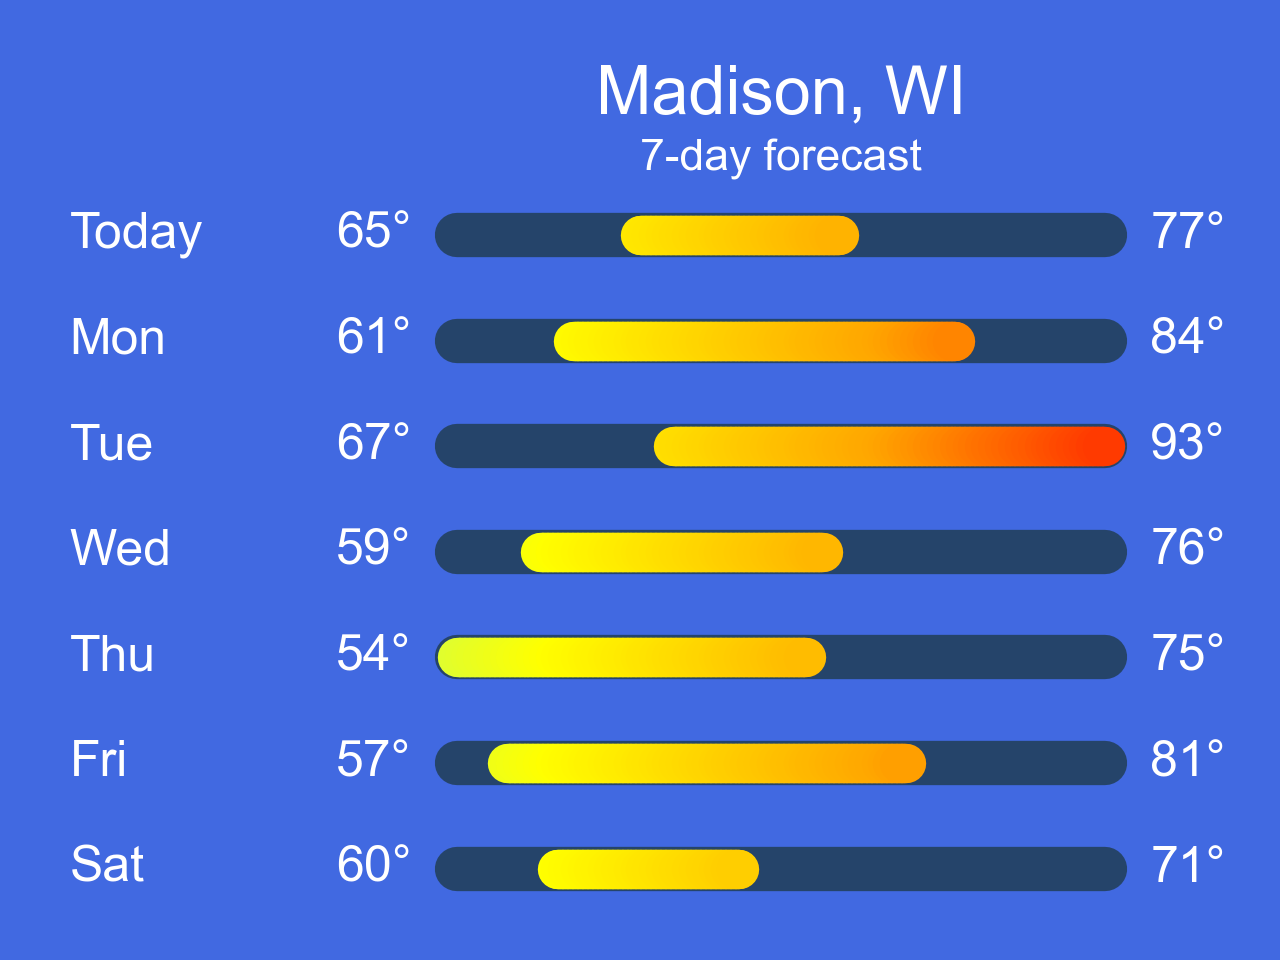

In [22]:
range_bg = 'xkcd:dark blue grey'
font_size = 18
font_family = 'Arial' # default is Helvetica; I think Arial looks a tiny bit better

plot = (
    p9.ggplot(plot_data, p9.aes(x='Temperature', y='Day'))
    + p9.labs(title="Madison, WI", subtitle="7-day forecast", x="", y="")
    + p9.geom_path(data=temp_range, size=9, color=range_bg, lineend='round', alpha=0.8)
    + p9.geom_path(p9.aes(color='Temperature'), size=8, lineend='round')
    + p9.geom_text(data=temp_labels, mapping=p9.aes(x='x', label='label'), color='white', size=font_size, ha='center', va='center')
    + p9.scale_color_gradientn(colors=['deepskyblue', 'aqua', 'palegreen', 'yellow', 'orange', 'red'], limits=[0, 100])
    + p9.scale_y_discrete(limits=raw_data['Day'].reverse().to_list(), expand=(0, 0.5, 0, 0.4))
    + p9.theme_void()
    + p9.theme(
        text=p9.element_text(family=font_family, color='white'),
        plot_background=p9.element_rect(fill='royalblue'),
        plot_title=p9.element_text(size=24),
        plot_subtitle=p9.element_text(size=16, ha='center'),
        plot_margin_top=0.05,
        plot_margin_right=0.04,
        plot_margin_bottom=0.03,
        plot_margin_left=-0.05,
        axis_text_y=p9.element_text(angle=0, size=font_size, va='center', ha='left', margin={'t': 0, 'r': 95, 'b': 0, 'l': 0, 'units': 'pt'}),
        axis_text_x=p9.element_blank(),
        legend_position='none',
    )
)
plot.show()

## Plot with weather icons

Let's take a quick look at using `watermark` to add `.png` images to a plot.
The `watermark` feature takes the path to an image, and x and y pixel coordinates, then places the image with respect to the origin, `[0, 0]`, which is the bottom-left corner of the plot.

I didn't expect it to work but I did try using an `.svg` image with `watermark` and it didn't work.

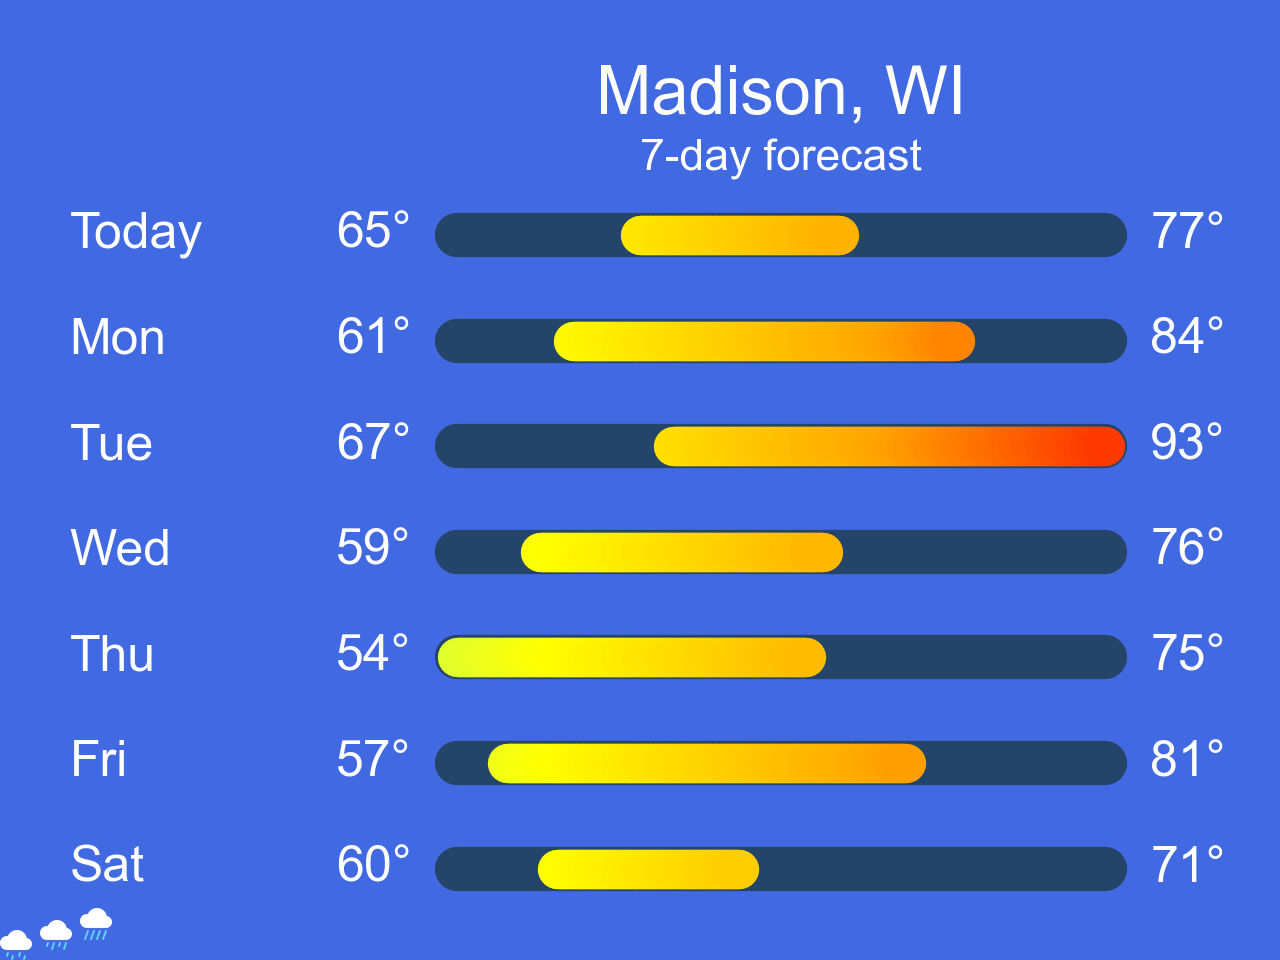

In [23]:
# add 3 weather icons to the plot in the bottom-left corner
(
    plot
    + p9.watermark('./img/drizzle_32px.png')
    + p9.watermark('./img/rain_32px.png', xo=40, yo=10)
    + p9.watermark('./img/heavy_rain_32px.png', xo=80, yo=20)
).show()

Since the coordinates are in pixels, this makes things a little trickier.
To handle this, I created a version of the plot at a specific resolution to figure out where the place the icons for each day.
I'm not going to use `plot.show()` since the placement probably will look off, but I'll save the plot to a file and then display it in this jupyter notebook.

In [24]:
raw_data

Day,Low,High,Conditions
cat,i64,i64,str
"""Today""",65,77,"""Cloudy"""
"""Mon""",61,84,"""Sunny"""
"""Tue""",67,93,"""Hot"""
"""Wed""",59,76,"""Drizzle"""
"""Thu""",54,75,"""Windy"""
"""Fri""",57,81,"""Partly cloudy"""
"""Sat""",60,71,"""Heavy rain"""


In [25]:
plot_w_icons = plot
xo = 120
yo_max = 509
yo_mod = 78

rows = raw_data.rows(named=True)
for i, row in enumerate(rows):
    yo = yo_max - i * yo_mod
    plot_w_icons = (
        plot_w_icons 
        + p9.watermark(f'./img/{row["Conditions"].lower().replace(" ", "_")}_32px.png', xo=xo, yo=yo)
    )

In [26]:
plot_w_icons.save(
    "weather.png",
    path="img",
    width=6.5,
    height=6.5,
    dpi=100,
    verbose=False
)

Here's the final plot:

![7-day forecast](img/weather.png)

I think this is a satisfying detail: zoom into the extreme low or high temperature on the plot and see the border formed by the underlayment around the temperature range.
![plot zoom](plot_zoom.png)

# Concluding notes

I put the code to generate the plot in a function in `plot_forecast.py`; the function doesn't have data validation or error checking.
You can run `from plot_forecast import plot_forecast`, then call `plot_forecast(forecast, location, outfile)` to generate a plot.
Go back to the [README](README.md) to see a bit more info about this.

While testing out `plot_forecast` on a wider range of data, I found some things to tweak:

* I adjusted `scale_color_gradientn` to tweak the colors
    * My original colors gave less contrast that I wanted at the colder temperatures
    * Note that I'm working in Fahrenheit and if you want to use Celsius, adjust the color scale accordingly
* The offset for the temperature labels is now calculated dynamically; a narrow temperature range with the static offset messed with the spacing of elements
* I added a call to `scale_x_continuous`: without it, temperatures with 3 digits were slightly clipped

I included 11 weather icons but there are additional weather icons available in the Bootstrap Icons library.

I learned some new things while working on this.
If you went through this notebook, I hope you did too.